In [2]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.applications import VGG16, ResNet50, ResNet50V2, Xception

### Keras의 Pretrained 모델 로딩 및 모델 구조확인

In [3]:
model = VGG16()
model.summary()

553476096/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [4]:
model = VGG16(input_shape=(32, 32, 3), include_top=False, weights='imagenet')
model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

### Keras의 Model 역시 Functional임. 

In [5]:
print('model:', model)
print('model output:', model.output)

model: <keras.engine.functional.Functional object at 0x000001D33F0FC700>
model output: KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, 512), dtype=tf.float32, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'")


### Pretrained 모델을 기반으로 CIFAR 10 분류 모델 재 생성. 

In [6]:
IMAGE_SIZE = 32
BATCH_SIZE = 64

In [9]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE ,3), include_top=False, weights='imagenet')
bm_output = base_model.output

x = GlobalAveragePooling2D()(bm_output)
# x = Dropout(rate=0.5)(x)
x = Dense(50, activation='relu')(x)
# x = Dropout(rate=0.2)(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

### 데이터 전처리 및 ImageDataGenerator로 Augmentation 설정하고 학습용, 검증용 Generator 생성

In [10]:
import tensorflow as tf
import numpy as np
import pandas as pd

import random as python_random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

# seed 를 설정해서 학습시마다 동일한 결과 유도. 불행히도 의도한 대로 동작하지 않음. 
def set_random_seed(seed_value):
    np.random.seed(seed_value)
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)

# 0 ~ 1사이값의 float32로 변경하는 함수
def get_preprocessed_data(images, labels, scaling=True):
    
    # 학습과 테스트 이미지 array를 0~1 사이값으로 scale 및 float32 형 변형. 
    if scaling:
        images = np.array(images/255.0, dtype=np.float32)
    else:
        images = np.array(images, dtype=np.float32)
        
    labels = np.array(labels, dtype=np.float32)
    
    return images, labels

# 0 ~ 1사이값 float32로 변경하는 함수 호출 한 뒤 OHE 적용 
def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels, scaling=False)
    # OHE 적용 
    oh_labels = to_categorical(labels)
    return images, oh_labels

# 학습/검증/테스트 데이터 세트에 전처리 및 OHE 적용한 뒤 반환 
def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021):
    # 학습 및 테스트 데이터 세트를  0 ~ 1사이값 float32로 변경 및 OHE 적용. 
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
    
    # 학습 데이터를 검증 데이터 세트로 다시 분리
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    
    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels ) 


# random seed는 2021로 고정.
set_random_seed(2021)
# CIFAR10 데이터 재 로딩 및 Scaling/OHE 전처리 적용하여 학습/검증/데이터 세트 생성. 
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
    get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021)

print(tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_oh_labels.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
(42500, 32, 32, 3) (42500, 10) (7500, 32, 32, 3) (7500, 10) (10000, 32, 32, 3) (10000, 10)


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    # rotation_range=20,
    #zoom_range=(0.7, 0.9),
    horizontal_flip=True,
    #vertical_flip=True,
    rescale=1/255.0
)
valid_generator = ImageDataGenerator(rescale=1/255.0)

flow_tr_gen = train_generator.flow(tr_images, tr_oh_labels, batch_size=BATCH_SIZE, shuffle=True)
flow_val_gen = valid_generator.flow(val_images, val_oh_labels, batch_size=BATCH_SIZE, shuffle=False)

### Keras CNN 모델 생성 함수. 

In [12]:
IMAGE_SIZE = 32
BATCH_SIZE = 64

In [13]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

def create_model(verbose=False):
    
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    bm_output = base_model.output

    x = GlobalAveragePooling2D()(bm_output)
    #x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu', name='fc1')(x)
    #x = Dropout(rate=0.2)(x)
    output = Dense(10, activation='softmax', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)
    if verbose:
        model.summary()
        
    return model

In [15]:
vgg_model = create_model(verbose=True)
vgg_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
# 10번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [16]:
# steps 횟수를 구하기 위해 학습 데이터의 건수와 검증 데이터의 건수를 구함. steps = ceil(학습 데이터 건수/BATCH_SIZE)
tr_data_len = tr_images.shape[0]
val_data_len = val_images.shape[0]
history = vgg_model.fit(flow_tr_gen, epochs=40, 
                    steps_per_epoch=int(np.ceil(tr_data_len/BATCH_SIZE)), 
                    validation_data=flow_val_gen,
                    validation_steps=int(np.ceil(val_data_len/BATCH_SIZE)),
                    callbacks=[rlr_cb, ely_cb])

Epoch 1/40
665/665 [==============================] - 29s 38ms/step - loss: 1.8313 - accuracy: 0.2745 - val_loss: 1.5043 - val_accuracy: 0.4052 - lr: 0.0010
Epoch 2/40
665/665 [==============================] - 25s 37ms/step - loss: 1.3544 - accuracy: 0.4858 - val_loss: 1.2531 - val_accuracy: 0.5468 - lr: 0.0010
Epoch 3/40
665/665 [==============================] - 24s 36ms/step - loss: 1.0752 - accuracy: 0.6185 - val_loss: 1.0242 - val_accuracy: 0.6481 - lr: 0.0010
Epoch 4/40
665/665 [==============================] - 24s 36ms/step - loss: 0.8899 - accuracy: 0.6936 - val_loss: 0.8235 - val_accuracy: 0.7125 - lr: 0.0010
Epoch 5/40
665/665 [==============================] - 24s 36ms/step - loss: 0.7824 - accuracy: 0.7324 - val_loss: 0.8665 - val_accuracy: 0.7067 - lr: 0.0010
Epoch 6/40
665/665 [==============================] - 24s 36ms/step - loss: 0.6952 - accuracy: 0.7680 - val_loss: 0.7260 - val_accuracy: 0.7597 - lr: 0.0010
Epoch 7/40
665/665 [==============================] - 24s 

In [17]:
test_generator = ImageDataGenerator(rescale=1/255.0)
flow_test_gen = test_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
vgg_model.evaluate(flow_test_gen)

157/157 [==============================] - 2s 12ms/step - loss: 0.8400 - accuracy: 0.8404


[0.8400310277938843, 0.840399980545044]

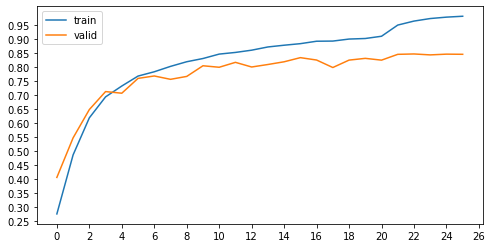

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(8, 4))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.xticks(np.arange(0, 30, 2))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    
show_history(history)

### 지금까지의 로직들을 함수화 

In [20]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import numpy as np
import pandas as pd
import cv2

import random as python_random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception

# seed 를 설정해서 학습시마다 동일한 결과 유도. 불행히도 의도한 대로 동작하지 않음. 
def set_random_seed(seed_value):
    np.random.seed(seed_value)
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)

# 0 ~ 1사이값의 float32로 변경하는 함수
def get_preprocessed_data(images, labels, scaling=True):
    
    # 학습과 테스트 이미지 array를 0~1 사이값으로 scale 및 float32 형 변형. 
    if scaling:
        images = np.array(images/255.0, dtype=np.float32)
    else:
        images = np.array(images, dtype=np.float32)
        
    labels = np.array(labels, dtype=np.float32)
    
    return images, labels

# 0 ~ 1사이값 float32로 변경하는 함수 호출 한 뒤 OHE 적용 
def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels, scaling=False)
    # OHE 적용 
    oh_labels = to_categorical(labels)
    return images, oh_labels

# 학습/검증/테스트 데이터 세트에 전처리 및 OHE 적용한 뒤 반환 
def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021):
    # 학습 및 테스트 데이터 세트를  0 ~ 1사이값 float32로 변경 및 OHE 적용. 
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
    
    # 학습 데이터를 검증 데이터 세트로 다시 분리
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    
    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels ) 

# 입력 image의 크기를 resize 값 만큼 증가. CIFAR10의 이미지가 32x32로 작아서 마지막 feature map의 크기가 1로 되어 모델 성능이 좋지 않음. 
# 마지막 feature map의 크기를 2로 만들기 위해 resize를 64로 하여 입력 이미지 크기를 변경. 단 메모리를 크게 소비하므로 64이상은 kernel이 다운됨. 
def get_resized_images(images, resize=64):
    image_cnt = images.shape[0]
    resized_images = np.zeros((images.shape[0], resize, resize, 3))
    for i in range(image_cnt):
        resized_image = cv2.resize(images[i], (resize, resize))
        resized_images[i] = resized_image
    
    return resized_images

def create_model(model_name='vgg16', verbose=False):
    
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50':
        base_model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception':
        base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    
    bm_output = base_model.output

    x = GlobalAveragePooling2D()(bm_output)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu', name='fc1')(x)
    output = Dense(10, activation='softmax', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)
    model.summary()
        
    return model

In [3]:
IMAGE_SIZE = 32
BATCH_SIZE = 64

def do_cifar10_train_evaluation(image_size=IMAGE_SIZE, model_name='vgg16'):
    set_random_seed(2021)
    # CIFAR10 데이터 재 로딩 및 Scaling/OHE 전처리 적용하여 학습/검증/데이터 세트 생성. 
    (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
    (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
        get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021)
    print('데이터 세트 shape:', tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_oh_labels.shape)
    
    # 만약 image_size가 32보다 크면 이미지 크기 재조정. 
    if image_size > 32:
        tr_images = get_resized_images(tr_images)
        val_images = get_resized_images(val_images)
        test_images = get_resized_images(test_images)
    
    # 학습/검증/테스트용 ImageDataGenerator와 flow로 pipeline 생성. 
    train_generator = ImageDataGenerator(
        horizontal_flip=True,
        rescale=1/255.0
    )
    valid_generator = ImageDataGenerator(rescale=1/255.0)
    test_generator = ImageDataGenerator(rescale=1/255.0)

    flow_tr_gen = train_generator.flow(tr_images, tr_oh_labels, batch_size=BATCH_SIZE, shuffle=True)
    flow_val_gen = valid_generator.flow(val_images, val_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
    flow_test_gen = train_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
    
    # model_name 에 따른 모델 생성하고 모델 학습 및 검증 수행. 
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
    rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
    # 10번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
    ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
    
    tr_data_len = tr_images.shape[0]
    val_data_len = val_images.shape[0]
    history = model.fit(flow_tr_gen, epochs=40, 
                        steps_per_epoch=int(np.ceil(tr_data_len/BATCH_SIZE)), 
                        validation_data=flow_val_gen, validation_steps=int(np.ceil(val_data_len/BATCH_SIZE)),
                        callbacks=[rlr_cb, ely_cb])
    # 테스트 데이터 세트로 모델 성능 검증 
    evaluation_result = model.evaluate(flow_test_gen)
    print('테스트 데이터 세트 evaluation 결과:', evaluation_result)
    return history, evaluation_result

In [4]:
import gc

gc.collect()

0

In [5]:
# 만약 image_size를 64로 하려면 반드시 RAM이 여유분이 충분히 있는지 확인
history, evaluation_result = do_cifar10_train_evaluation(image_size=64, model_name='xception')

데이터 세트 shape: (42500, 32, 32, 3) (42500, 10) (7500, 32, 32, 3) (7500, 10) (10000, 32, 32, 3) (10000, 10)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 15, 15, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 15, 15, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                        

665/665 [==============================] - 78s 103ms/step - loss: 0.7672 - accuracy: 0.7475 - val_loss: 0.6129 - val_accuracy: 0.8172 - lr: 0.0010
Epoch 2/40
665/665 [==============================] - 65s 98ms/step - loss: 0.4076 - accuracy: 0.8683 - val_loss: 0.3907 - val_accuracy: 0.8725 - lr: 0.0010
Epoch 3/40
665/665 [==============================] - 67s 100ms/step - loss: 0.3131 - accuracy: 0.8981 - val_loss: 0.5870 - val_accuracy: 0.8048 - lr: 0.0010
Epoch 4/40
665/665 [==============================] - 69s 103ms/step - loss: 0.2551 - accuracy: 0.9169 - val_loss: 0.4925 - val_accuracy: 0.8572 - lr: 0.0010
Epoch 5/40
665/665 [==============================] - 68s 103ms/step - loss: 0.2122 - accuracy: 0.9321 - val_loss: 0.4695 - val_accuracy: 0.8653 - lr: 0.0010
Epoch 6/40
665/665 [==============================] - 67s 101ms/step - loss: 0.1792 - accuracy: 0.9411 - val_loss: 0.3210 - val_accuracy: 0.9007 - lr: 0.0010
Epoch 7/40
665/665 [==============================] - 68s 102ms/

In [6]:
print('테스트 데이터세트 검증 결과:', evaluation_result)

테스트 데이터세트 검증 결과: [0.38580048084259033, 0.9294999837875366]


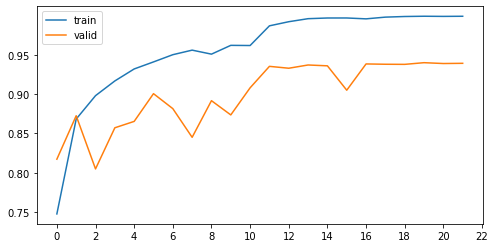

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(8, 4))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.xticks(np.arange(0, 30, 2))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    
show_history(history)